## 빅데이터 활용 AI 설계
# DCGAN : Cifar-10 이미지 적용

In [0]:
import numpy as np
import matplotlib.pyplot as plt

### Cifar-10 로딩

In [2]:
from keras.datasets import cifar10

Using TensorFlow backend.


In [3]:
(X_train, y_train), (_, _) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [4]:
X_train.shape, X_train.dtype, X_train.max(), X_train.min()

((50000, 32, 32, 3), dtype('uint8'), 255, 0)

In [5]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

- 자동차 사진만 뽑아낸다 (5000개)

In [0]:
X_train = X_train[y_train.ravel()==1]/255 # 자동차

In [7]:
X_train.shape, X_train.dtype, X_train.max(), X_train.min()

((5000, 32, 32, 3), dtype('float64'), 1.0, 0.0)

- 흑백 사진으로 바꾼다

In [0]:
X_train = X_train.mean(axis=-1)[:,:,:,np.newaxis]

In [9]:
X_train.shape, X_train.dtype, X_train.max(), X_train.min()

((5000, 32, 32, 1), dtype('float64'), 1.0, 0.0)

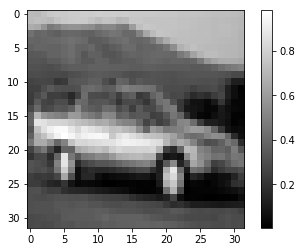

In [10]:
plt.imshow(X_train[0,:,:,0], cmap='gray') # 32*32*1 이므로 채널값을 0으로 놓음
plt.colorbar()

### 판별자 정의

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, \
    Flatten, Reshape, LeakyReLU, BatchNormalization, Activation
from keras.optimizers import RMSprop

In [24]:
input = Input((32,32,1))
x = LeakyReLU(alpha=0.2)(input)

x = Conv2D(32, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(64, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(128, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(256, (5,5), strides=1, padding='same')(x)

x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(input, x)
discriminator.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        832       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 128)         2049

In [0]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=2e-4, decay=6e-8), metrics=['acc'])

### 생성자 정의

In [26]:
input = Input((100,)) # 생성벡터는 100차원

x = Dense(8*8*128)(input)
x = Reshape((8,8,128))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(128, (5,5), strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(64, (5,5), strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(32, (5,5), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(1, (5,5), strides=1, padding='same')(x)
x = Activation('sigmoid')(x)

generator = Model(input, x)
generator.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
activation_6 (Activation)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 16, 16, 128)       409728    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)       512 

### 적대망 정의

In [27]:
discriminator.trainable = False

adversarial = Model(input, discriminator(generator(input)))
adversarial.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_5 (Model)              (None, 32, 32, 1)         1495425   
_________________________________________________________________
model_4 (Model)              (None, 1)                 1080577   
Total params: 2,576,002
Trainable params: 1,494,721
Non-trainable params: 1,081,281
_________________________________________________________________


In [0]:
adversarial.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=2e-4*0.5, decay=6e-8*0.5), metrics=['acc'])

### 훈련하기
- fake images: 0, real images: 1
- 1 step 에 13초 정도 소요됨
- gan_images 폴더에 'car_10.png' 형태로 저장함
- 생성자 모델을 'gan_car_generator_1000.h5' 로 저장함

In [0]:
! mkdir gan_cifar10_images

In [0]:
! ls gan_cifar10_images

In [29]:
from keras.preprocessing import image

batch_size = 64
logs = []

for step in range(1000): # 40000
    idx = np.random.randint(0, len(X_train), size=batch_size)
    real_images = X_train[idx]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    fake_images = generator.predict(gen_vectors)
    
    X = np.r_[real_images, fake_images] # [batch_size*2,32,32,1]
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    ###########
    a_loss, a_acc = adversarial.train_on_batch(gen_vectors_2, np.ones([batch_size,1]))
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, [%.3f, %.3f, %.3f, %.3f]' % (step+1,d_loss,d_acc,a_loss,a_acc))
    
    if (step+1)%10 == 0:
        #adversarial.save_weights('gan_car.h5')
    
        img = image.array_to_img(fake_images[0]*255., scale=False)
        img.save('gan_cifar10_images/car_%05d.png' % (step+1))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 00001, [0.693, 0.508, 0.775, 0.000]
Step: 00002, [0.709, 0.500, 0.854, 0.000]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 00003, [0.670, 0.984, 0.783, 0.000]
Step: 00004, [0.702, 0.500, 0.797, 0.000]
Step: 00005, [0.708, 0.484, 0.841, 0.000]
Step: 00006, [0.713, 0.508, 0.865, 0.000]
Step: 00007, [0.674, 0.516, 0.800, 0.000]
Step: 00008, [0.686, 0.758, 0.716, 0.016]
Step: 00009, [0.685, 0.453, 0.654, 1.000]
Step: 00010, [0.672, 0.484, 0.603, 1.000]
Step: 00011, [0.691, 0.477, 0.624, 1.000]
Step: 00012, [0.685, 0.477, 0.665, 0.969]
Step: 00013, [0.672, 0.438, 0.614, 1.000]
Step: 00014, [0.665, 0.461, 0.706, 0.234]
Step: 00015, [0.675, 0.461, 0.657, 0.969]
Step: 00016, [0.666, 0.422, 0.863, 0.000]
Step: 00017, [0.674, 0.695, 0.660, 0.891]
Step: 00018, [0.664, 0.438, 0.841, 0.000]
Step: 00019, [0.643, 0.820, 0.826, 0.000]
Step: 00020, [0.665, 0.688, 0.636, 0.922]
Step: 00021, [0.680, 0.422, 1.023, 0.000]
Step: 00022, [0.731, 0.602, 0.622, 0.969]
Step: 00023, [0.682, 0.406, 0.716, 0.219]
Step: 00024, [0.690, 0.430, 0.755, 0.031]
Step: 00025, [0.670, 0.703, 0.780, 0.016]
Step: 00026, [0.692, 0.617, 0.795,

In [30]:
for step in range(1000,10000):
    idx = np.random.randint(0, len(X_train), size=batch_size)
    real_images = X_train[idx]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    fake_images = generator.predict(gen_vectors)
    
    X = np.r_[real_images, fake_images] # [batch_size*2,32,32,1]
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    ###########
    a_loss, a_acc = adversarial.train_on_batch(gen_vectors_2, np.ones([batch_size,1]))
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, [%.3f, %.3f, %.3f, %.3f]' % (step+1,d_loss,d_acc,a_loss,a_acc))
    
    if (step+1)%10 == 0:
        #adversarial.save_weights('gan_car.h5')
    
        img = image.array_to_img(fake_images[0]*255., scale=False)
        img.save('gan_cifar10_images/car_%05d.png' % (step+1))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 01001, [0.583, 0.633, 0.282, 0.984]
Step: 01002, [0.647, 0.570, 1.017, 0.375]
Step: 01003, [0.663, 0.625, 0.385, 0.938]
Step: 01004, [0.611, 0.648, 0.895, 0.469]
Step: 01005, [0.610, 0.633, 0.438, 0.875]
Step: 01006, [0.546, 0.680, 0.722, 0.547]
Step: 01007, [0.553, 0.750, 0.504, 0.844]
Step: 01008, [0.564, 0.750, 0.634, 0.719]
Step: 01009, [0.535, 0.773, 0.559, 0.766]
Step: 01010, [0.539, 0.766, 0.633, 0.734]
Step: 01011, [0.514, 0.781, 0.749, 0.531]
Step: 01012, [0.464, 0.867, 1.072, 0.344]
Step: 01013, [0.505, 0.789, 0.555, 0.781]
Step: 01014, [0.677, 0.562, 1.313, 0.125]
Step: 01015, [0.857, 0.547, 0.501, 0.844]
Step: 01016, [0.562, 0.680, 0.602, 0.688]
Step: 01017, [0.557, 0.758, 0.509, 0.812]
Step: 01018, [0.612, 0.695, 0.457, 0.953]
Step: 01019, [0.536, 0.750, 0.730, 0.516]
Step: 01020, [0.488, 0.836, 0.716, 0.547]
Step: 01021, [0.546, 0.773, 0.584, 0.766]
Step: 01022, [0.588, 0.664, 0.762, 0.438]
Step: 01023, [0.571, 0.734, 0.538, 0.859]
Step: 01024, [0.577, 0.656, 0.807,

In [0]:
generator.save('gan_car_generator_10000.h5')

- 총 10000번 배치 실행 (이전 1000번 + 신규 9000번)

n = 1000


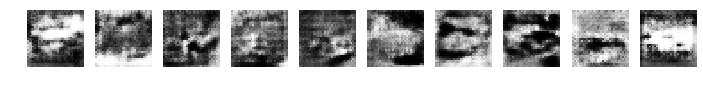

n = 2000


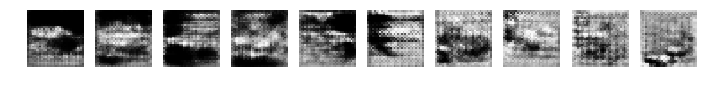

n = 3000


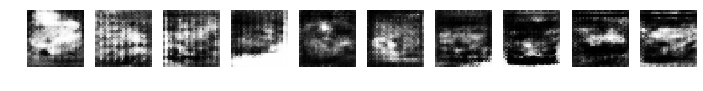

n = 4000


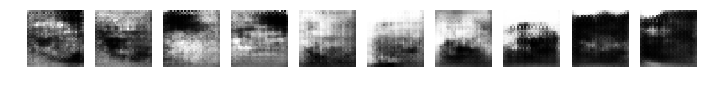

n = 5000


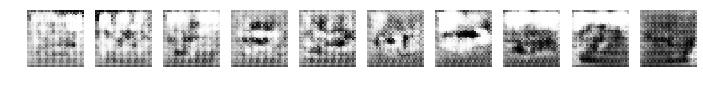

n = 6000


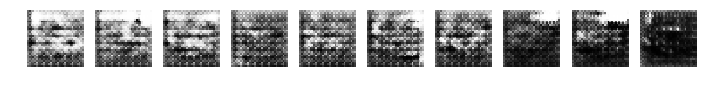

n = 7000


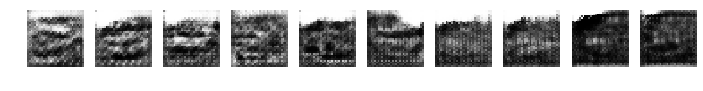

n = 8000


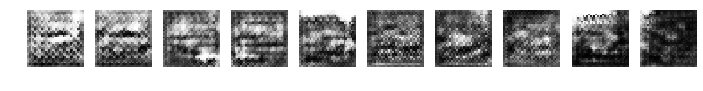

n = 9000


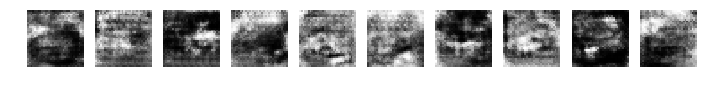

In [32]:
for n in range(1000, 10000, 1000):
  print('n =',n)
  plt.figure(figsize=[12,10])
  
  for i in range(10):
    plt.subplot(1,10,i+1)
    img = plt.imread('gan_cifar10_images/car_%05d.png' %(n+10*i))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
   
  plt.show()

### 자동차 이미지 생성

In [0]:
from keras.models import load_model

#generator = load_model('gan_car_generator_1200.h5')

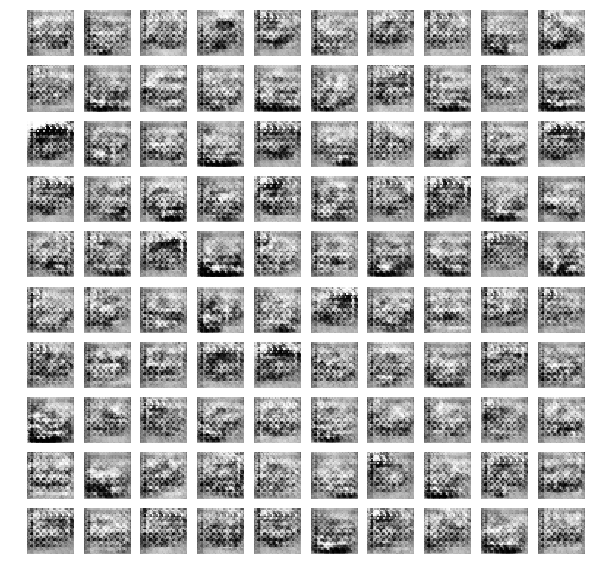

In [34]:
vectors = np.random.uniform(-1, 1, size=[100,100])
images = generator.predict(vectors)

plt.figure(figsize=[10,10])
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(images[i].reshape(32,32), cmap='gray')
    plt.axis('off')

### 결과 분석

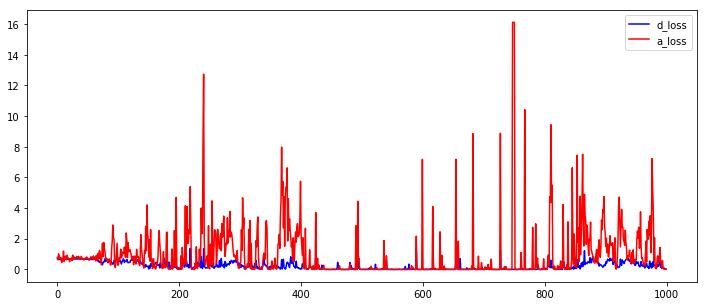

In [35]:
plt.figure(figsize=[12,5])

plt.plot([i[0] for i in logs][::10], 'b-', label='d_loss')
plt.plot([i[2] for i in logs][::10], 'r-', label='a_loss')
plt.legend()

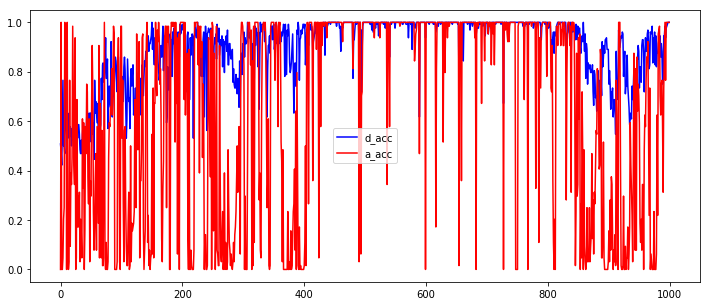

In [36]:
plt.figure(figsize=[12,5])

plt.plot([i[1] for i in logs][::10], 'b-', label='d_acc')
plt.plot([i[3] for i in logs][::10], 'r-', label='a_acc')
plt.legend()